均线：前N天的移动平均值
日均线：5天 10天
季均线：30天 60天
年均线：120天 240天
金叉：短期均线上穿长期均线，买入信号
死叉：短期均线下穿

In [10]:
import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [11]:
stock_record = ak.stock_zh_a_hist(symbol='000001', start_date='20100101', adjust='hfq').iloc[:, :5]
stock_record.columns = ['date', 'open', 'close', 'high', 'low']
# 指定列索引，要重新赋值。如果是从csv文件读取，默认第一列是index
stock_record = stock_record.set_index('date')

In [16]:
# stock_record['ma5'] = np.nan
# ma_day = 5
# for i in range(4, len(stock_record)):
#   stock_record.loc[stock_record.index[i], 'ma5'] = stock_record['close'][i - 4: i + 1].mean()
# rolling
stock_record['ma5'] = stock_record['close'].rolling(5).mean()
stock_record['ma30'] = stock_record['close'].rolling(30).mean()
# mpl finace包， mav函数可以直接

,open,close,high,low,ma5,ma30
date,,,,,,
2010-01-04,1402.93,1355.31,1406.45,1353.55,NaN,NaN
2010-01-05,1357.66,1331.21,1366.48,1298.88,NaN,NaN
2010-01-06,1328.27,1307.70,1328.27,1297.12,NaN,NaN
2010-01-07,1307.70,1293.00,1316.51,1278.30,NaN,NaN
2010-01-08,1284.18,1290.06,1298.88,1275.37,1315.456,NaN
...,...,...,...,...,...,...
2023-01-04,2434.16,2533.30,2549.55,2421.15,2397.428,2322.554000
2023-01-05,2546.30,2559.30,2601.56,2541.42,2440.984,2336.964667
2023-01-06,2562.55,2582.06,2598.31,2559.30,2492.668,2352.405000


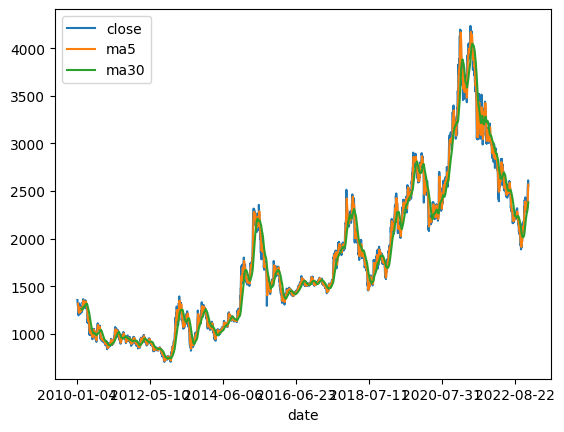

In [17]:
stock_record[['close', 'ma5', 'ma30']].plot()
plt.show()

In [19]:
stock_record = stock_record.dropna()

# 金叉
(stock_record['ma5'] - stock_record['ma30']).index

Index(['2010-02-12', '2010-02-22', '2010-02-23', '2010-02-24', '2010-02-25',
       '2010-02-26', '2010-03-02', '2010-03-03', '2010-03-04', '2010-03-05',
       ...
       '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30', '2023-01-03',
       '2023-01-04', '2023-01-05', '2023-01-06', '2023-01-09', '2023-01-10'],
      dtype='object', name='date', length=3066)